In [153]:
from dateutil.relativedelta import relativedelta
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt  # data visualization
import matplotlib.dates as mdates
import warnings
from dateutil.relativedelta import relativedelta
from module import myFunctions
import seaborn as sns
import os.path
import statsmodels.api as sm
import importlib
from pandas.plotting import autocorrelation_plot

def reloadMyModule():
    importlib.reload(myFunctions)

warnings.filterwarnings(action='ignore')
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)

showGraphs = True

%matplotlib inline


In [154]:
# Any results you write to the current directory are saved as output.

path_to_file = "./data/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv"

if not (os.path.exists(path_to_file)):
    raise Exception("File not found. Please download the file from the link below and place it in the data folder https://www.kaggle.com/datasets/mczielinski/bitcoin-historical-data")

coinbase = pd.read_csv(path_to_file)

coinbase.describe()
coinbase.tail()
coinbase.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4857377 entries, 0 to 4857376
Data columns (total 8 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Timestamp          int64  
 1   Open               float64
 2   High               float64
 3   Low                float64
 4   Close              float64
 5   Volume_(BTC)       float64
 6   Volume_(Currency)  float64
 7   Weighted_Price     float64
dtypes: float64(7), int64(1)
memory usage: 296.5 MB


Filtrar intervalo de dados

In [155]:
reloadMyModule()

historical_per_minute = myFunctions.filterByInterval(coinbase, relativedelta(months=12))

if myFunctions.hasMissingData(historical_per_minute['Timestamp'].values):
    raise Exception("Missing data in the dataframe")

print("O intervalo entre datas é de {} até {}, somando um total de {} registros.".format(
    myFunctions.getFirstTimestamp(historical_per_minute), myFunctions.getLastTimestamp(historical_per_minute), historical_per_minute.shape[0]))


O intervalo entre datas é de 30/03/2020 21:00:00 até 30/03/2021 21:00:00, somando um total de 525601 registros.


# Análise e Exploração dos Dados 

## Prepara os dados históricos agrupandos por hora

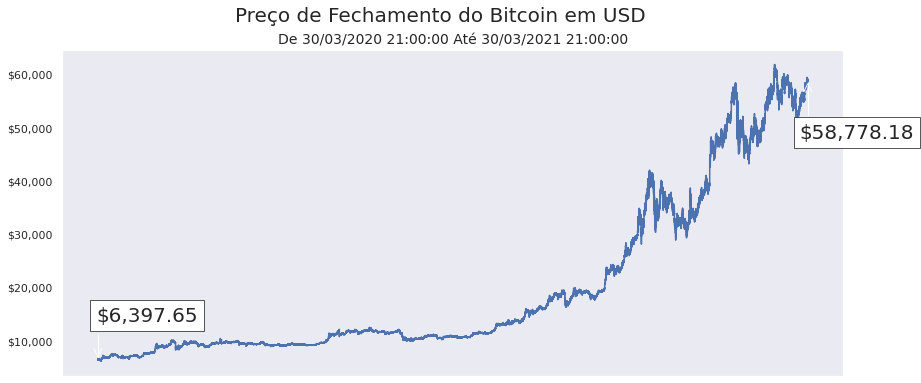

In [156]:
reloadMyModule()

if showGraphs:
    kw = dict(annot_yaxis=10000, annot_xaxis=-1000, annot_xaxis_pos=-6000, annot_yaxis_pos=-
              8000, angle="angle,angleA=0,angleB=90", angle_pos="angle,angleA=0,angleB=-90", showAnnotate=True)
    myFunctions.figureCloses(historical_per_minute, 'Close', **kw)


## Gráfico Volatility

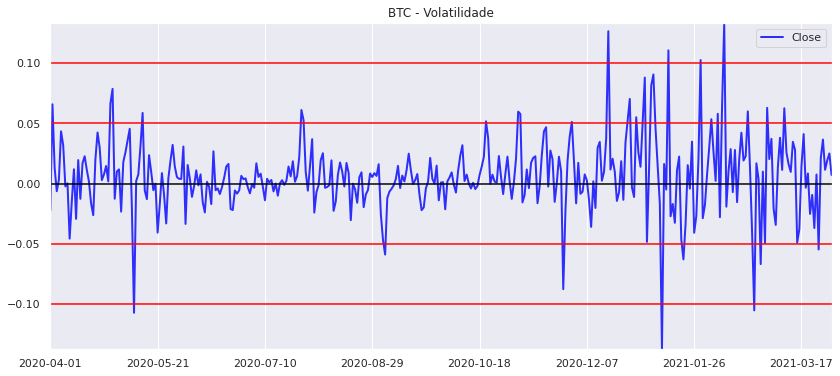

In [157]:
def volatiltyGraph(data):
    returns = data.pct_change().dropna(axis=0)
    plt.figure(figsize=(14, 6))
    plt.title('BTC - Volatilidade')
    plt.grid()
    returns['Close'].plot(label='Close', color='blue',
                          linewidth=2, alpha=0.8, legend=True)
    plt.autoscale(tight=True)
    plt.axhline(y=0, color='black')
    plt.axhline(y=0.05, color='red')
    plt.axhline(y=-0.05, color='red')
    plt.axhline(y=0.1, color='red')
    plt.axhline(y=-0.1, color='red')
    plt.xlabel(None)

    plt.show()


historical_per_day = myFunctions.groupByDay(historical_per_minute)
if showGraphs:
    volatiltyGraph(historical_per_day)


## Heatmap

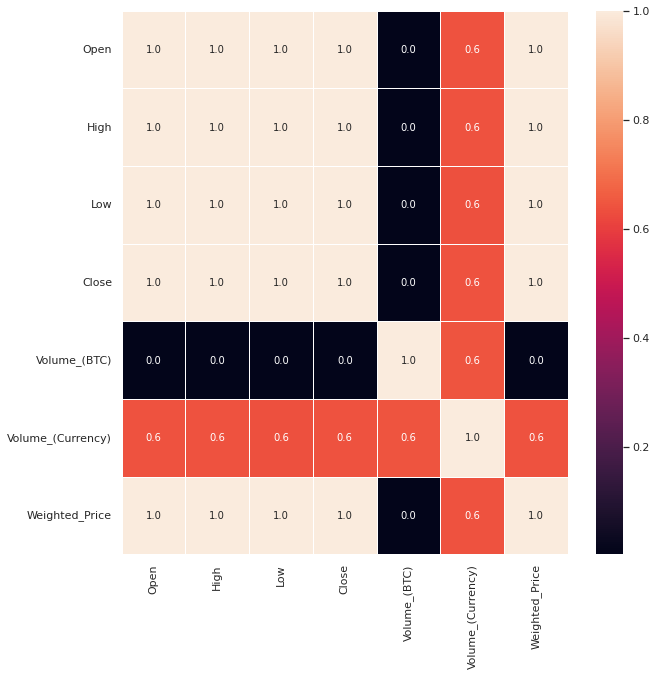

In [158]:
def heatmapGraph(data):
    f, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(data.corr(), annot=True,
                linewidths=.9, fmt='.1f', ax=ax)
    plt.show()


historical_per_hour = myFunctions.groupByHour(historical_per_minute)
if showGraphs:
    heatmapGraph(historical_per_day)


## Dia da semana com valor mais baixo

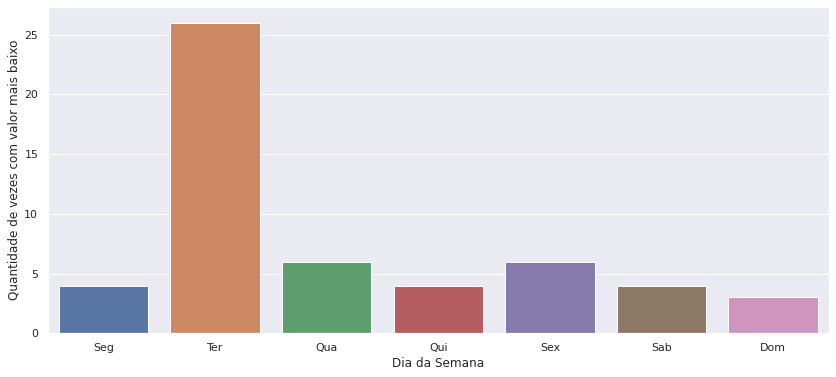

In [159]:
def lowestDuringWeek(data):
    data.Timestamp = pd.to_datetime(data.Timestamp, unit='s')
    data = data.dropna()

    week = {0: 'Seg', 1: 'Ter', 2: 'Qua',
            3: 'Qui', 4: 'Sex', 5: 'Sab', 6: 'Dom'}
    data['Dia da Semana'] = data['Timestamp'].dt.dayofweek.map(week)

    # count min value for each week day
    idx = data.groupby([pd.Grouper(key='Timestamp', freq='W-MON')]
                       )['Close'].transform(min) == data['Close']

    # data is still in minutes, so I calculate it for days.
    lows_count = data[idx].groupby(
        [pd.Grouper(key='Timestamp', freq='D')]).first().reset_index()
    lows_count = lows_count.dropna()

    sns.set(rc={'figure.figsize': (14, 6)})
    ax = sns.countplot(x='Dia da Semana', data=lows_count, order=[
                       'Seg', 'Ter', 'Qua', 'Qui', 'Sex', 'Sab', 'Dom'])
    ax.set(ylabel='Quantidade de vezes com valor mais baixo')


if showGraphs:
    lowestDuringWeek(historical_per_minute)


Preparação dos Dados

In [160]:
data = historical_per_minute.Close
data = data.values
max = np.max(data)
data = data/max

Separar dados de Treino e Teste

In [163]:
X = [data[i:i+10] for i in range(len(data)-11)]
Y = [data[i+10] for i in range(len(data)-11)]
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.25, shuffle=False)
X_train = np.array(X_train)
X_test = np.array(X_test)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)



X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

AttributeError: 'numpy.ndarray' object has no attribute 'head'

Criação do Modelo

In [162]:
np.random.seed(0)

lstm = LSTM(64, activation='relu')

model = Sequential([
    Bidirectional(lstm, input_shape=(1, 10)),
    Dropout(0.15),
    Dense(1)
])
model.compile(loss='mse', optimizer='adam')
history = model.fit(X_train, Y_train, epochs=20)


Epoch 1/20
  239/12319 [..............................] - ETA: 1:01 - loss: nan

KeyboardInterrupt: 

Treinamento do Modelo

In [ ]:
pred_train = model.predict(X_train)

print("Mean absolute error regression loss: %.4f" %
      mean_absolute_error(Y_train, pred_train))
print("Root mean squared error regression loss: %.4f" %
      np.sqrt(mean_squared_error(Y_train, pred_train)))
print("R2 score: %.4f" % r2_score(Y_train, pred_train))


Gráfico da função de perda

In [ ]:
if showGraphs:
    plt.figure(figsize=(8, 8))
    plt.title("Loss evolution")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.plot(history.history['loss'])

Gráfico da predição comparado com os dados de teste

In [ ]:
if showGraphs:
    preds1 = pred_train * max
    plt.figure(figsize=(12, 12))
    plt.plot(Y_train * max, c='red', label='predicted values', linewidth=2)
    plt.plot(preds1, c='blue', label='real values', linewidth=2)
    plt.xlabel("Days")
    plt.title("prediction on train data")
    plt.legend()


Gráfico da predição comparado com os dados de validação

In [ ]:
if showGraphs:
    preds = model.predict(X_test) * max
    plt.figure(figsize=(14, 14))
    plt.plot(preds, c='red', label='predicted values', linewidth=2)
    plt.plot(Y_test * max, c='blue', label='real values', linewidth=2)
    plt.xlabel("Days")
    plt.title("prediction on test data")
    plt.legend()


Train using LSTM 

In [ ]:
# # The LSTM architecture
# regressor = Sequential()
# # First LSTM layer with Dropout regularisation
# regressor.add(LSTM(units=50, return_sequences=True,
#               input_shape=(X_train.shape[1], 1)))
# regressor.add(Dropout(0.2))

# # Second LSTM layer
# regressor.add(LSTM(units=50, return_sequences=True))
# regressor.add(Dropout(0.2))

# # Third LSTM layer
# regressor.add(LSTM(units=50, return_sequences=True))
# regressor.add(Dropout(0.5))

# # Fourth LSTM layer
# regressor.add(LSTM(units=50))
# regressor.add(Dropout(0.5))

# # The output layer
# regressor.add(Dense(units=1))

# # Compiling the RNN
# regressor.compile(optimizer='adam', loss='mean_absolute_error')
# # Fitting to the training set
# regressor.fit(X_train, y_train, epochs=1, batch_size=500)


This is clearly overfitting